# Example notebook for pairwise registration using GreedyFHist



### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.ndarray`.

In [1]:
import os
from os.path import exists, join
import matplotlib.pyplot as plt

from greedyfhist.data_types import Image, Pointset
from greedyfhist.registration import GreedyFHist, RegistrationResult
from greedyfhist.options import RegistrationOptions
from greedyfhist.utils.io import read_image, write_to_ometiffile

In [2]:
OUTPUT_DIR = 'out'
if not exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'

moving_image = Image.load_from_path(path_to_moving_image)
fixed_image = Image.load_from_path(path_to_fixed_image)

In [4]:
moving_img = moving_image.data
fixed_img = fixed_image.data

Text(0.5, 1.0, 'Fixed Image')

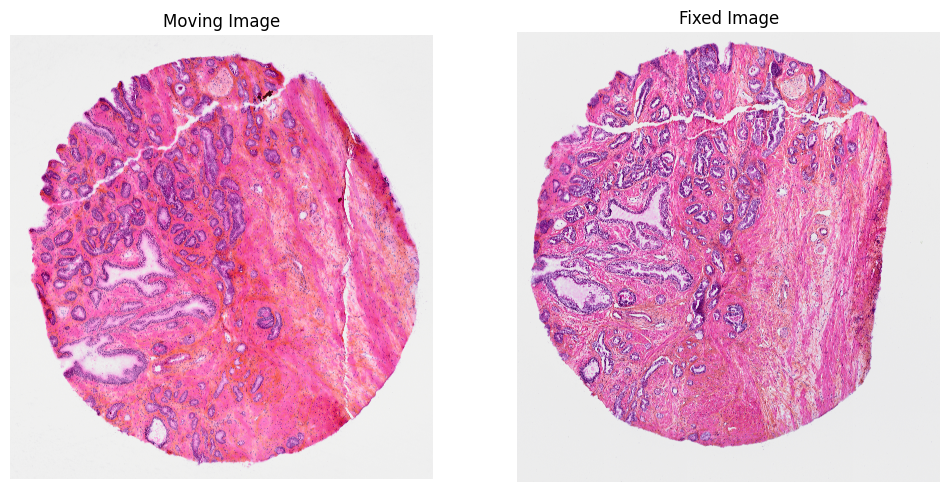

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')

### Step 2: Setting registration options and performing registration.

In [6]:
# Set this option only to True, if greedy is used as an external docker image.
# If MIIT, GreedyFHist and Greedy are used from with the same docker container or if
# from no docker container at all, set this to False.

# Normally, this option can stay as False.
use_greedyfhist_from_external_docker_container = False

if use_greedyfhist_from_external_docker_container:
    path_to_greedy = 'mwess89/greedy:1.3.0-alpha'
    use_docker_container = True
else:
    path_to_greedy = 'greedy'
    use_docker_container = False
    
path_to_greedy = '../../../test/greedy/build2/greedy'

registerer = GreedyFHist(path_to_greedy=path_to_greedy, use_docker_container=use_docker_container)

In [7]:

# Default options do not need to be parsed
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8
# For large images we recommend to use downscaling.
# options.pre_sampling_factor = 0.25

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

A registration result consists of 2 transformations: A forward transformation from moving to fixed image space and a backward transformation from fixed to moving image space. Internally transformations are executed using SimpleITK. Forward transformations are used to transform image data, backward transformations are used for pointset valued data.

In [8]:
warped_moving_image = registerer.transform_image(moving_image.data, registration_result.registration.forward_transform)

Text(0.5, 1.0, 'Transformed Image')

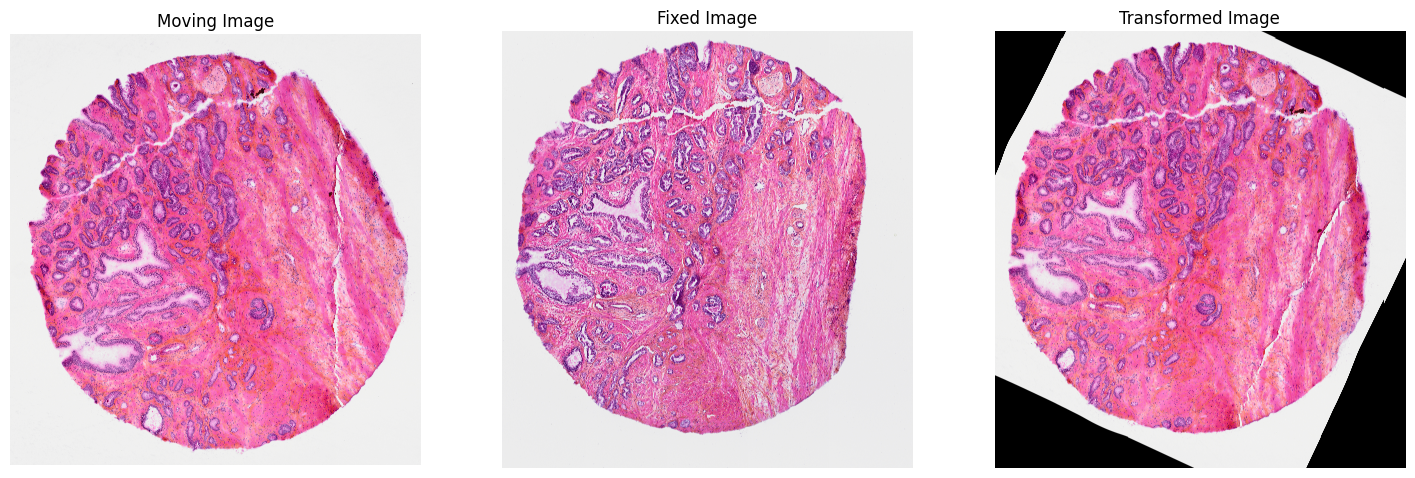

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(warped_moving_image)
axs[2].set_title('Transformed Image')

### Step 3: Saving and loading transformation data

Transformations can be stored and loaded at a later point.

In [10]:
registration_result.to_directory(join(OUTPUT_DIR, 'saved_transform'))
loaded_reg_result = RegistrationResult.load(join(OUTPUT_DIR, 'saved_transform'))

In [11]:
warped_image2 = registerer.transform_image(moving_image.data, loaded_reg_result.registration.forward_transform, 'LINEAR')

In [12]:
ps  = Pointset.load_from_path('../pairwise_examples/annotations/moving_pointset.csv')
warped_ps = registerer.transform_pointset(ps.to_numpy(), loaded_reg_result.registration.backward_transform)

Text(0.5, 1.0, 'Warped image from loaded registration.')

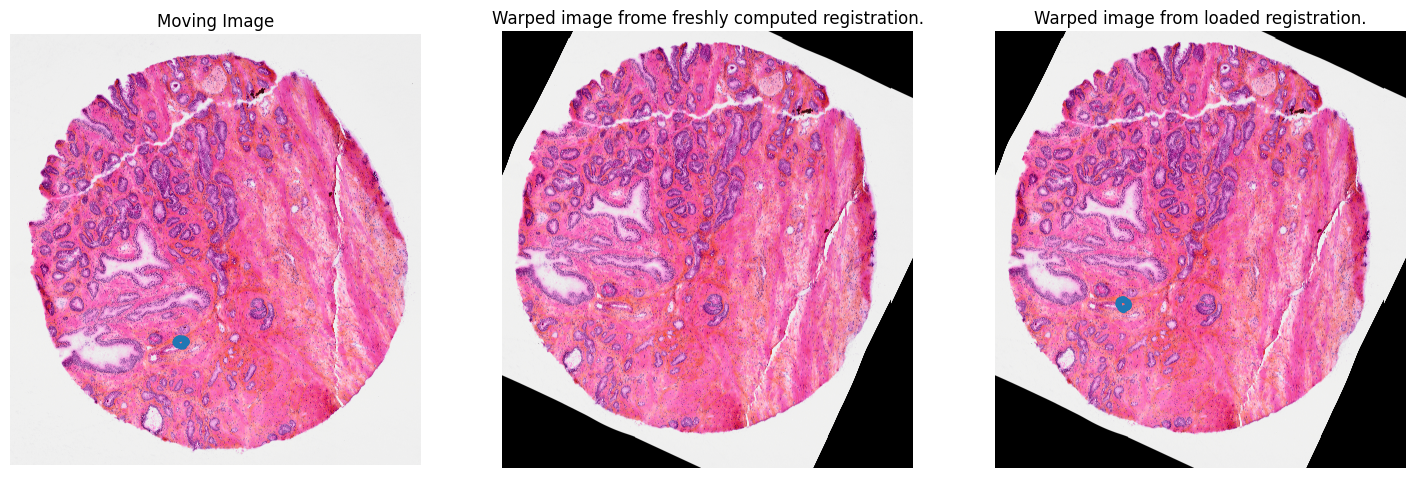

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
ps_np = ps.to_numpy()
axs[0].plot(ps_np[:, 0], ps_np[:, 1], '.')
axs[0].set_title('Moving Image')
axs[1].imshow(warped_moving_image)
axs[1].set_title('Warped image frome freshly computed registration.')
axs[2].imshow(warped_image2)
axs[2].plot(warped_ps[:, 0], warped_ps[:, 1], '.')
axs[2].set_title('Warped image from loaded registration.')

### Alternative: Registration using filepaths

Alternatively, GreedyFHist has a helper function that allows us to register images by supplying filepaths. The registered image is stored as an `ome.tif`. 

In [14]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'
path_to_warped_image = join(OUTPUT_DIR, 'warped_image.ome.tif')
path_to_saved_transform = join(OUTPUT_DIR, 'saved_transform2')

registerer = GreedyFHist(path_to_greedy=path_to_greedy)

registration_result, warped_image = registerer.register_from_filepaths(path_to_moving_image, 
                                                                       path_to_fixed_image, 
                                                                       path_to_warped_image,
                                                                       transform_path=path_to_saved_transform)

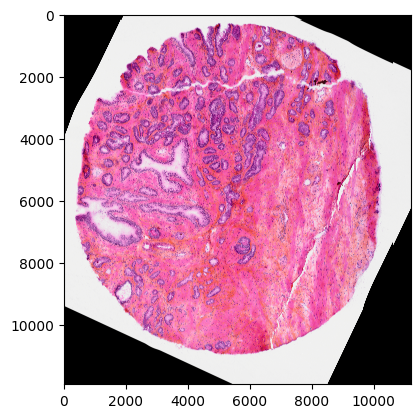

In [15]:
warped_image_loaded = read_image(path_to_warped_image)[0].data
plt.imshow(warped_image_loaded)

### Tiling Registration

Normally the non-rigid registration will be enough to fidn an accurate registration between fixed and moving image. However, in some cases, the downscaling can be too strict and `greedy` itself has an upper limit for how high the resolution of fixed and moving image can be.
To avoid loss of information due to downscaling and offer more flexibility we have implemented a tiling registration mode:

Prealigned images (e.g., from affine registration) are cut into smaller tiles. Matching tiles between moving and fixed image can then be registered independently at a higher resolution. After each pair of tiles has been registered, the transformations are stitched back together. 

For the registration of each tile pair, we use the nonrigid registration options.

Getting into the function.


Text(0.5, 1.0, 'Warped image')

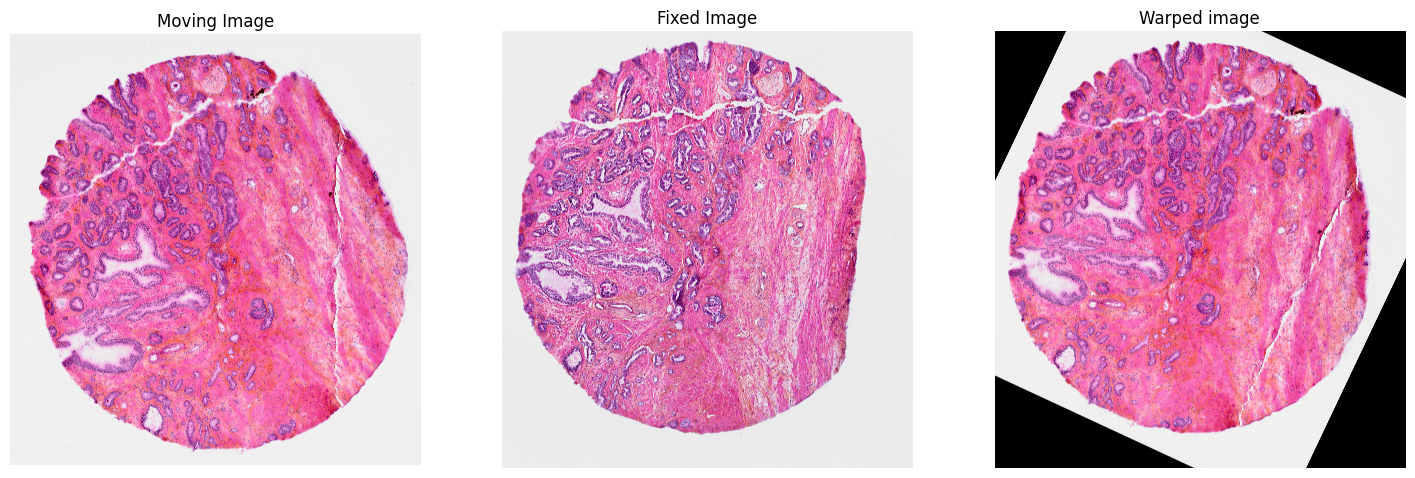

In [7]:
# First we do a quick affine registration
# We can do affine and tiling in one go. This is just for demonstration purposes.
options = RegistrationOptions()
options.do_nonrigid_registration = False
options.affine_registration_options.n_threads = 8

# For large images we recommend to use downscaling.
# options.pre_sampling_factor = 0.25

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

affine_trans_image = registerer.transform_image(moving_image.data, registration_result.registration.forward_transform)

fig, axs = plt.subplots(1, 3, figsize=(18 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(affine_trans_image)
axs[2].set_title('Warped image')

In [ ]:
# We can now do a tiling nonrigid registration.

options = RegistrationOptions()
options.do_affine_registration = False

# We enable tiling by setting the flag
options.tiling_options.enable_tiling = True

# We choose a size for tiles.
options.tiling_options.tile_size = (8126, 8126)

# To ensure that stitched transformations are smooth, we set some minimum overlap
options.tiling_options.min_overlap = 0.5

# We can set n_procs to a number to perform the registration concurrently.
options.tiling_options.n_procs = 6



In [9]:
# The image here is a larger and will take longer to be processed.

tiling_reg_result = registerer.register(affine_trans_image, fixed_image.data, options=options, verbose=True)

Performing tiling registration.
Doing simple tiling registration.
Number of extracted tiles: 4.
Number of pools used: 6
RegistrationOptions(path_to_greedy='../../../test/greedy/build2/greedy', segmentation=None, use_docker_container=False, affine_registration_options=AffineGreedyOptions(dim=2, resolution=(1024, 1024), preprocessing_options=PreprocessingOptions(moving_sr=30, moving_sp=25, fixed_sr=30, fixed_sp=25, enable_denoising=True, disable_denoising_moving=False, disable_denoising_fixed=False), kernel_size=10, cost_function='ncc', rigid_iterations=10000, ia='ia-com-init', iteration_pyramid=[100, 100, 50, 10], n_threads=1, keep_affine_transform_unbounded=True, dof=12), nonrigid_registration_options=NonrigidGreedyOptions(dim=2, resolution=(2048, 2048), preprocessing_options=PreprocessingOptions(moving_sr=30, moving_sp=25, fixed_sr=30, fixed_sp=25, enable_denoising=False, disable_denoising_moving=False, disable_denoising_fixed=False), s1=5, s2=4, kernel_size=10, cost_function='ncc', i

TypeError: cannot pickle 'onnxruntime.capi.onnxruntime_pybind11_state.InferenceSession' object

In [7]:
tiling_warped_image = registerer.transform_image(affine_trans_image, tiling_reg_result.registration.forward_transform)

NameError: name 'registerer' is not defined

NameError: name 'affine_trans_image' is not defined

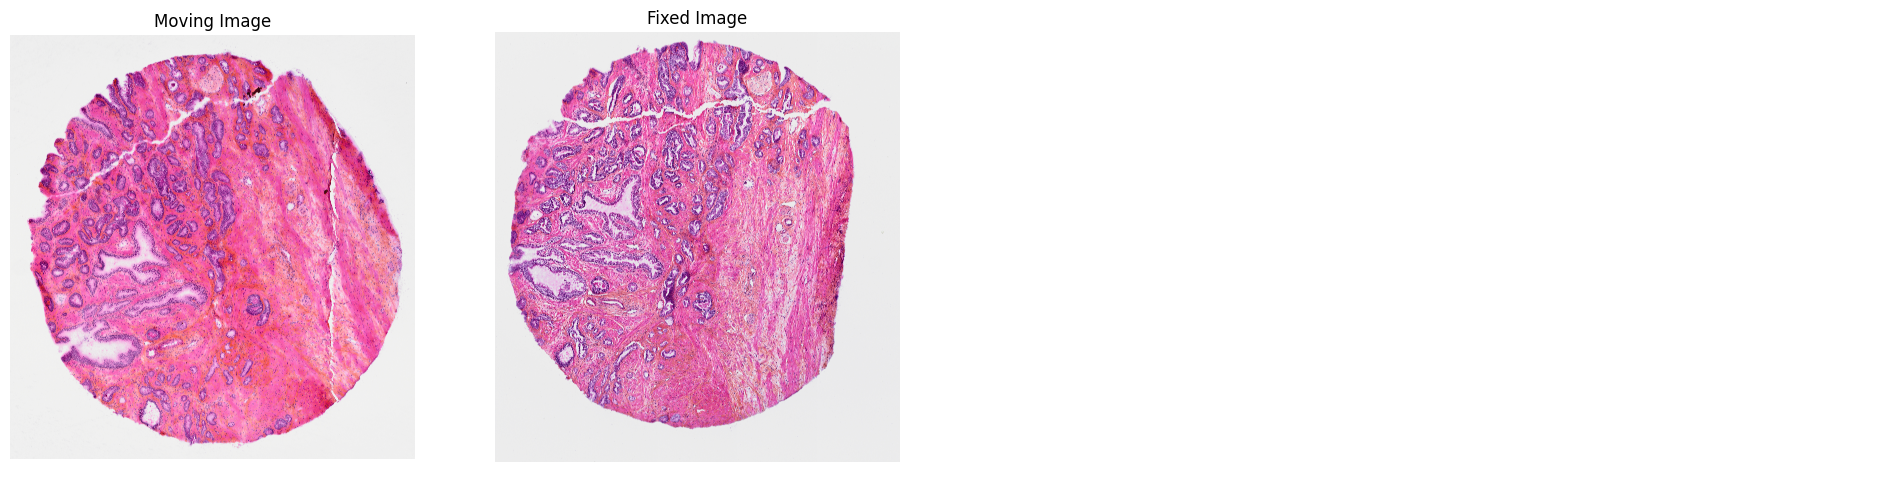

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(24 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(affine_trans_image)
axs[2].set_title('Affine warped image')
axs[3].imshow(tiling_warped_image)
axs[3].set_title('Nonrigid warped image.')

In [ ]:
class inference(object):
    def __init__(self):
        # os.environ['CUDA_VISIBLE_DEVICES'] = '7'
        self.features = list()
        self.ort_sess = onnxruntime.InferenceSession(model_path)
        self.input_name = self.ort_sess.get_inputs()[0].name

    def run(self, img):
        pass
        # image = preprocess(img_paths, args.height, args.width)
        # if image is not None:
        #     feat = self.ort_sess.run(None, {self.input_name: image})[0]
        #     feat = normalize(feat, axis=1)
        #     self.features.append(feat)


# if __name__ == "__main__":
#     args = get_parser().parse_args()
#     img_paths = glob.glob(os.path.join(args.input, '*.jpg'))
#     pool = Pool(processes=1)
#     pool.map(inference().run, img_paths)
#     pool.close()
#     pool.join()
    
    

import onnxruntime as ort
import onnxruntime

class WrapInferenceSession:

    def __init__(self, onnx_bytes):
        self.sess = ort.InferenceSession(onnx_bytes.SerializeToString())
        self.onnx_bytes = onnx_bytes

    def run(self, *args):
        return self.sess.run(*args)

    def __getstate__(self):
        return {'onnx_bytes': self.onnx_bytes}

    def __setstate__(self, values):
        self.onnx_bytes = values['onnx_bytes']
        self.sess = ort.InferenceSession(self.onnx_bytes.SerializeToString())  
        
        
from greedyfhist.segmentation.segmentation import _resolve_path_to_model

model_path = _resolve_path_to_model()
model_path

In [ ]:
infe = inference(model_path)

In [ ]:
import multiprocess

pool = multiprocess.Pool(processes=1)
pool.map(inference().run, [1,2,3,4])